# Summarize raw posts into themes

In [106]:
!pip install --upgrade boto3 botocore pandas anthropic faiss-cpu openai plotly matplotlib google-cloud google-auth wordcloud retry plotly kaleido google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.3 MB/s eta 0:00:00ta 0:00:01


# Prompts

In [38]:
import time, os
common_prompt = "You are an AI assistant analyzing Russian and Ukrainian social media posts."
folder_path = './data/' + str(int(time.time()))
os.makedirs(folder_path, exist_ok=True)

# Clients

In [2]:
!gcloud auth application-default login

from anthropic import AnthropicVertex
PROJECT_ID = 'auspicious-lead-386121'
REGION = 'us-central1'

claude_client = AnthropicVertex(project_id=PROJECT_ID, region=REGION)


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=jDk9ZJ8q2DV9XsUrSt92P9g0GWtj3h&access_type=offline&code_challenge=fw0RWSoo8x2ZsCqqzDDvz1TJ3r_KU6Q9KTNIV0wznm0&code_challenge_method=S256


Credentials saved to file: [/Users/shah/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "auspicious-lead-386121" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


Updates are available for some Google Cloud

In [3]:
import boto3
import pandas as pd
from io import BytesIO
from botocore import UNSIGNED
from botocore.config import Config


# # Create a boto3 session with an anonymous user
# s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# bucket_name = 'vl-nat-sec-hackathon-may-2024'
# file_key = 'russia_social_media.csv'

# # Get the object from S3
# response = s3.get_object(Bucket=bucket_name, Key=file_key)

# file_content = response['Body'].read()

# Also available here: https://vl-nat-sec-hackathon-may-2024.s3.us-east-2.amazonaws.com/russia_social_media.csv



In [8]:
# Load the file content into a pandas DataFrame
data = pd.read_csv('~/Downloads/russia_social_media.csv').dropna(subset=['translation', 'description'])


In [9]:
data.describe()

,id,time,body,translation,external_url,profile_type,description,name,attachment_urls
count,444238,444238,444238,444238,444238,444238,444238,444238,444238
unique,444238,404773,410490,409825,980,2,837,972,444210
top,0007ed21-eb78-597d-9558-9dfa4f75ed3e,2024-04-05 11:22:47,@mobikRUT,@mobikRUT,https://t.me/itsdonetsk,telegram,The Telegram channel of a Russian mil blogger.,itsdonetsk,media/vk/3416ea5d-4889-4a9b-942d-0d1518b5e438....
freq,1,13,458,458,6661,417398,7455,6661,11


In [11]:
start_date = '2024-04-01'
end_date = '2024-04-02'

data = data.loc[(data['time'] >= start_date)
                & (data['time'] < end_date)]

In [12]:
data.describe()

,id,time,body,translation,external_url,profile_type,description,name,attachment_urls
count,7866,7866,7866,7866,7866,7866,7866,7866,7866
unique,7866,7089,7496,7488,695,2,620,693,7866
top,00006495-8e9b-5273-98c4-8ed43463433f,2024-04-01 18:19:06,Forwarded from: Владлен Татарский\nОбодритесь!,Forwarded from: Vladlen Tatarsky\nCheer up!,https://t.me/karga4,telegram,The Telegram channel of a Russian mil blogger.,karga4,media/telegram-web/79c6fec6-9e20-42c0-ba1f-941...
freq,1,11,19,19,113,7406,165,113,1


In [13]:
data = data.sample(1000)

In [47]:
data['description']

451630    Telegram channel focused on Russia-Ukraine con...
451344    A Telegram channel affiliated with the Russian...
452651    The aggressively Kremlin-aligned Telegram chan...
458118    Telegram channel focused on Russian news and R...
457630    A Russian language Telegram account that focus...
                                ...                        
450172    Flash News Aggregator for Russo-Ukrainian Conf...
453351              The official Telegram channel of UNIAN.
454351    The Telegram account of the National News Agen...
458045    A VK channel spreading Kremlin propaganda, par...
452097    The Telegram account of one Andrey Rudenko, a ...
Name: description, Length: 1000, dtype: object

# Tagging

In [55]:
tag_prompt = """Convert each post into a list of comma separated tags surrounded by the <tags> which best describe the post. 

Use tags which are useful for defense and national security. Here are some guidelines:
1. Tags for specific events like "Crimean annexation," "Donbas conflict," "Minsk agreements," "NATO expansion," etc.
2. Names of key political figures such as "Putin," "Zelensky," "Medvedev," "Poroshenko," etc.
3. Tags related to governmental bodies like "Kremlin," "Verkhovna Rada," "Duma," "Security Service of Ukraine (SBU)," "FSB," etc.
4. Tags indicating potential propaganda or disinformation efforts such as "Russian propaganda," "Ukrainian disinformation," "Information warfare," "Fake news," etc.
5. Tags for military operations like "Operation Barbarossa," "Operation Northern Wind," "ATO (Anti-Terrorist Operation)," "Russian military intervention," etc.
6. Tags related to civil society movements and activism like "Protests," "Civil rights," "Activism," "Civil society organizations," etc.
7. Tags for ethnic and cultural identity like "Russian identity," "Ukrainian nationalism," "Crimean Tatars," "Donbas Russians," etc.
8. Tags for economic factors affecting the region such as "Sanctions," "Economic downturn," "Energy dependence," "Trade agreements," etc.

If the post is not interesting in terms of national security, please tag it as "Others".
Do not add more than 3 tags to a post.


Try to judge the emotion of the post and put it inside a searate <emotion> tag. Emotions should be in the range of -2, -1, 0, 1 and 2.
Also, put a <location> based on the post.

"""


import re
from retry import retry

@retry(delay=50, tries=5)
def tag(posts):
    prompt = f"""{common_prompt}
    
{tag_prompt}

Now, I am going to give you a list of posts and description of the posters. Please create tags for them.
Output only <tags> not the post.

"{posts}"

    """
    # print(prompt)
    
    try: 
        message = claude_client.messages.create(
            model="claude-3-sonnet@20240229",
            # model="claude-3-haiku@20240307",
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
        )
    except Exception as e:
        print(e)
        raise e
        
    # print(message.content[0].text)
    pattern = r'<tags>(.*?)<\/tags>'

    # Find all matches
    matches = re.findall(pattern, message.content[0].text)
    results = []
    
    for match in matches:
        results.append(match.split(','))
    
    return results

In [ ]:
batch_size = 20

# Create an empty list to store the results
results = []

# Iterate over the DataFrame in batches
for i in range(0, len(data), batch_size):
    batch_df = data.iloc[i:i+batch_size]  # Get the current batch
    
    posts = ''
    for j in range(0, len(batch_df)):
        row = batch_df.iloc[j]
        posts += f"""
<post>
{row['translation']}
<poster>
{row['description']}
</poster>
</post>
""" 
    tags = tag(posts)
    print(f'batch_start: {i}, batch_size: {len(tags)}')
    tags.extend([[]] * (batch_size - len(tags)))
    results.extend(tags)  # Append the processed batch to the results list
    time.sleep(10)



batch_start: 0, batch_size: 20
batch_start: 20, batch_size: 20
batch_start: 40, batch_size: 18
batch_start: 60, batch_size: 19
Error code: 429 - {'error': {'code': 429, 'message': 'Quota exceeded for aiplatform.googleapis.com/online_prediction_tokens_per_minute_per_base_model with base model: anthropic-claude-3-sonnet. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.', 'status': 'RESOURCE_EXHAUSTED'}}
batch_start: 80, batch_size: 18


In [18]:
data['tags'] = results[:1000]

In [19]:
data.to_csv(f"./{folder_path}/tagged_tweets.csv", index=False)

In [37]:
data['attachment_urls']

451630    media/telegram-web/6aa9a40e-4d38-45ec-abff-6d8...
451344    media/telegram-web/56164790-6846-4f55-8255-7a6...
452651    media/telegram-web/0d958f7d-06b7-408c-940b-198...
458118    media/telegram-web/9e3a231b-5661-4640-b7b2-8ef...
457630    media/telegram-web/98b2298f-f447-4725-a6a2-d3e...
                                ...                        
450172    media/telegram-web/93906cce-a059-432f-afb5-c89...
453351    media/telegram-web/6d719fa9-5c4d-453b-822a-de2...
454351    media/telegram-web/9ccb34ae-9cab-4bbb-bf1f-815...
458045    media/vk/955e185e-2b89-45a9-9b31-f76ede85a1b9....
452097    media/telegram-web/b0f17499-d0ae-4422-b606-f99...
Name: attachment_urls, Length: 1000, dtype: object

In [21]:
# Create a flat list of tags from the 'Tags' column
all_tags = [tag.strip() for sublist in data['tags'] for tag in sublist]

# Count the occurrences of each tag
tag_counts = pd.Series(all_tags).value_counts()


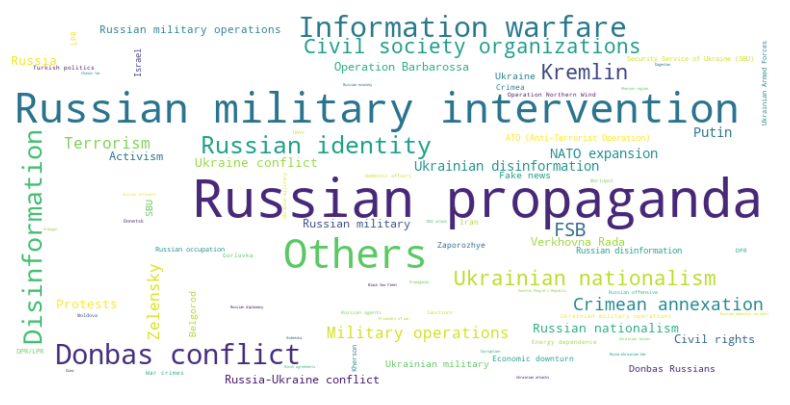

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud.to_file(f"./{folder_path}/word_cloud.png")


In [23]:
import plotly.express as px
fig = px.bar(tag_counts,
             labels={
                 "index": "Topics",
                 "value": "Frequency"
             },
            )
fig.update_layout(showlegend=False)
fig.show()
fig.write_image(f"./{folder_path}/freqency_chart.png")

## Summarize

In [24]:
target_tags = ["Russian propaganda", "Defection"]

In [25]:
filtered_df = data[data['tags'].apply(lambda x: any(tag in x for tag in target_tags))]


In [27]:
filtered_df = data

In [48]:
# CoT?
summarization_prompt = """Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.
"""

import re

@retry(delay=10, tries=4, backoff=2)
def summarize(posts):
    prompt = f"""{common_prompt}

{summarization_prompt}

Here are the posts:
<post>
{posts}
</post>

    """
    print(prompt)
    
    message = claude_client.messages.create(
        model="claude-3-sonnet@20240229",
        max_tokens=4096,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
    )
    
    # print(message.content[0].text)
    
    return message.content[0].text

In [49]:
batch_size = 100

# Create an empty list to store the results
themes = []

# Iterate over the DataFrame in batches
for i in range(0, len(filtered_df), batch_size):
    batch_df = filtered_df.iloc[i:i+batch_size]  # Get the current batch
    
    posts = """
</post>
<post>
""".join(batch_df['translation'])
    
    summary_result = summarize(posts)
    print(f'batch_start: {i}, batch_size: {len(summary_result)}')
    
    themes.append(summary_result)  # Append the processed batch to the results list
    time.sleep(10)

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Ukraine⚡️Unbreakable
At the Adidas company, it is forbidden to use the number "44" due to its "similarity with the SS symbol". The company explains this by the fact that after Adidas presented the new uniform of the German national football team, "many social network users saw the symbol of the Nazi SS organization in the font design of the T-shirt with the number 44".
•••Subscribe to the channel
</post>
<post>
Forwarded from: Guardian
Thank you, guys!
Vodyanoe.
</post>
<post>
On soci

batch_start: 0, batch_size: 2340
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Mihai Popsoi presented the Ambassador of Ukraine to Moldova Marko Shevchenko with the medal "For Diplomatic Merit" of the first degree.

Previously, we wrote that Vladimir Zelensky dismissed Shevchenko from his position. https://t.me/aifmd
</post>
<post>
⚡️Ministry of Foreign Affairs of the Russian Federation: The Taliban (the Taliban movement is banned in the Russian Federation) are invited to participate in the Russia - Islamic World forum in Kazan.
</post>
<post>
R

batch_start: 100, batch_size: 2557
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Engineers of the 60th brigade destroyed some kind of metal sausage😁Subscribe @Primorye_za
</post>
<post>
❗️The development of artificial intelligence (AI) can lead to the death of humanity with a probability of no more than 20%. This opinion was expressed by American entrepreneur Elon Musk.

"I think there is some probability that it will lead to the destruction of humanity. I would probably agree with [the estimate of British-Canadian artificial intelligence pionee

batch_start: 200, batch_size: 2225
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Kringe Department
Is it only a measly trillion euros that relatives of Makfa’s top executives have in assets? Yes, well, we live poorly, the third world https://www.rbc.ru/business/01/04/2024/6609fa5b9a794750d67aac9f RBKTASS named the amount of seized assets in the lawsuit for the seizure of “Makfa” In the lawsuit for the seizure of “Makfa”, the assets of relatives were seized in favor of the state owners of the company in the amount of 100 trillion 

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Kringe Department
Is it only a measly trillion euros that relatives of Makfa’s top executives have in assets? Yes, well, we live poorly, the third world https://www.rbc.ru/business/01/04/2024/6609fa5b9a794750d67aac9f RBKTASS named the amount of seized assets in the lawsuit for the seizure of “Makfa” In the lawsuit for the seizure of “Makfa”, the assets of relatives were seized in favor of the state owners of the company in the amount of 100 trillion rubles, the shares were also seized

batch_start: 300, batch_size: 2280
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
The "Peak" tower was created in Russia to protect ships and airfields from drones. Russian specialists developed the "Peak" tower to protect the ships of the Russian Navy, the infrastructure of the Russian Armed Forces and airfields from drone attacks.

The new development is a complex of long-distance digital communications. “Pik is installed on the towers of airfield control towers and ship masts to ensure stable communication so that the pilot of an FPV drone can

batch_start: 400, batch_size: 2858
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Governor General N
Russians do not want to go live abroad for the first time since 1991. According to the results of a survey by VTsIOM, the share of Russian citizens who want to go abroad for permanent residence has reached a minimum for the entire measurement period - only 5%. This hasn’t happened since 1991. 64% of respondents believe that you need to live in the country where you grew up and received your education. Well, or, to tell the plain tr

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Governor General N
Russians do not want to go live abroad for the first time since 1991. According to the results of a survey by VTsIOM, the share of Russian citizens who want to go abroad for permanent residence has reached a minimum for the entire measurement period - only 5%. This hasn’t happened since 1991. 64% of respondents believe that you need to live in the country where you grew up and received your education. Well, or, to tell the plain truth, without hiding behind “lofty w

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Forwarded from: Governor General N
Russians do not want to go live abroad for the first time since 1991. According to the results of a survey by VTsIOM, the share of Russian citizens who want to go abroad for permanent residence has reached a minimum for the entire measurement period - only 5%. This hasn’t happened since 1991. 64% of respondents believe that you need to live in the country where you grew up and received your education. Well, or, to tell the plain truth, without hiding behind “lofty w

batch_start: 500, batch_size: 2483
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
A mother and son from Simferopol ordered the murder of his ex-wife and father-in-law so as not to divide their property.

They entrusted the reprisal to an acquaintance for 2.5 million and told him where the former relatives often visited. The killer turned his clients over to the police, and recently showed them staged photos as proof.

While handing over the money, the family of monsters was detained.
</post>
<post>
🔥The journalists were shown the Marder infantry 

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
A mother and son from Simferopol ordered the murder of his ex-wife and father-in-law so as not to divide their property.

They entrusted the reprisal to an acquaintance for 2.5 million and told him where the former relatives often visited. The killer turned his clients over to the police, and recently showed them staged photos as proof.

While handing over the money, the family of monsters was detained.
</post>
<post>
🔥The journalists were shown the Marder infantry fighting vehicle, previously captur

batch_start: 600, batch_size: 2448
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
The Investigative Committee of the Russian Federation will check the statements of the singer Manizha with a view to justifying terrorism.

Earlier, a native of Dushanbe Khamraeva, who in 2021 mocked the image of a Russian woman at Eurovision, recorded a video message in which she called the detention of the terrorists who attacked Crocus City Hall “public torture.” @voenkorKotenok
</post>
<post>
Forwarded from: From Mariupol to the Carpathians
Mariupol. AzovStal. U

batch_start: 700, batch_size: 2093
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
The next, tenth participant in the organization of the terrorist attack at Crocus City Hall, Yusufzoda Yakubjoni, was arrested until May 22. This preventive measure was chosen by the Basmanny Court of Moscow.
"The court granted the investigator's request to select a preventive measure in the form of detention in relation to Yusufzoda Y.D. until May 22, 2024"
Show more
.
The defendant was charged under paragraph “b” of Part 3 of Art. 205 of the Criminal Code of the R

batch_start: 800, batch_size: 2602
You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Good morning.

Vertical gigachads are already flying to work.
</post>
<post>
🇦🇺Recently in Australia, they washed the bones of the head of the Green Party, Adam Brandtuz, because he prefers to fight climate change from aboard a private jet, and even at public expense.

The Australian government clearly learned nothing from that story.

The other day, the Albanian Prime Minister and Energy Minister Bowen traveled from Canberra to the same event in the Hunter Province

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Good morning.

Vertical gigachads are already flying to work.
</post>
<post>
🇦🇺Recently in Australia, they washed the bones of the head of the Green Party, Adam Brandtuz, because he prefers to fight climate change from aboard a private jet, and even at public expense.

The Australian government clearly learned nothing from that story.

The other day, the Albanian Prime Minister and Energy Minister Bowen traveled from Canberra to the same event in the Hunter Province on two different private jets. At 

You are an AI assistant analyzing Russian and Ukrainian social media posts.

Here are the requirements:
1. Ignore any post unrelated to Russia-Ukraine conflict.
1. Collect interesting themes from similar posts. 
2. Put each theme inside <theme> tags.
3. Each theme will have 3 sections: <title>, <detail> and an optional <location>.
3. Put as much detail as possible inside each theme.
4. Include names of people, places, events etc. in the <detail> as appropriate.


Here are the posts:
<post>
Good morning.

Vertical gigachads are already flying to work.
</post>
<post>
🇦🇺Recently in Australia, they washed the bones of the head of the Green Party, Adam Brandtuz, because he prefers to fight climate change from aboard a private jet, and even at public expense.

The Australian government clearly learned nothing from that story.

The other day, the Albanian Prime Minister and Energy Minister Bowen traveled from Canberra to the same event in the Hunter Province on two different private jets. At 

batch_start: 900, batch_size: 2104


In [50]:
# pattern = r'<theme>((.|\n)*?)<\/theme>'

# Find all matches
# matches = re.findall(pattern, themes)  

themes


["Based on the posts provided, here are some interesting themes I identified:\n\n<theme>\n<title>Israeli airstrike on Iranian consulate in Syria</title>\n<detail>\nIsrael carried out an airstrike on the Iranian consulate building in Damascus, Syria, reportedly killing several high-ranking Iranian officials, including IRGC General Mohammad Zahedi and other senior military advisers. This attack is seen as a serious escalation, as Israel struck a diplomatic facility, violating the Vienna Convention. Iran is expected to retaliate, leading to further escalation in the region. The airstrike allegedly came in response to recent Iranian proxy attacks on an Israeli naval base in Eilat.\n</detail>\n<location>Damascus, Syria</location>\n</theme>\n\n<theme>\n<title>Russia-Ukraine conflict updates</title>\n<detail>\nThe posts covered various updates related to the ongoing Russia-Ukraine conflict, including:\n- Russian troops advancing and capturing positions around Avdiivka and other areas in the D

In [ ]:
themes_l1 = []

for match in matches:
    title_matches = re.findall(r'<title>((.|\n)*?)<\/title>', match[0])
    detail_matches = re.findall(r'<detail>((.|\n)*?)<\/detail>', match[0])
    # search_query_matches = re.findall(r'<search_query>((.|\n)*?)<\/search_query>', match[0])
    
    themes_l1.append({
        'title': title_matches[0][0].strip(),
        'detail': detail_matches[0][0].strip(),
        # 'search_query': search_query_matches[0][0],
        
    })
    


In [ ]:
pd.DataFrame(themes_l1).to_csv(f"./{folder_path}/themes_l1.csv", index=False)

In [113]:
# 1. Set up multiple variables to store the titles, text within the report
page_title_text='Social Media Summary'
title_text = 'Daily SITREP'


# 2. Combine them together using a long f-string

card_html = ''
for card in themes_l1:
    card_html += f"""
<h3>{card['title']}</h3>
{card['detail']}
"""

html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <img src='freqency_chart.png'>
            <p>Figure: most frequent topics in the posts</p>
            </br>
            </br>
            {card_html}
        </body>
    </html>
    '''
# 3. Write the html string as an HTML file
with open(f'./{folder_path}/summary.html', 'w') as f:
    f.write(html)


'1714712230'